# BEST NEIGHBORHOOD IN PITTSBURGH  
**Team: The Code Warriors**

## Introduction

In this project, we set out to answer the question: **What is the best neighborhood in Pittsburgh for families?** We used real data from WPRDC to compare different neighborhoods and figure out which one is the most family-friendly.

We looked at three things that are important to families:
- **Low crime rates** (safer neighborhoods)
- **High public school enrollment** (shows schools are available and families live there)
- **Low vacancy rates** (fewer empty homes means a more stable and active community)

We picked these because they are easy to measure, and they give a good idea of what living in a neighborhood might be like for a family. For each neighborhood, we gave a score for each of the three factors, then averaged them to find the overall best neighborhood.

At first, we thought about using other data, like air quality, parks, or commute times. But we decided to focus on crime, school enrollment, and vacancy rates because:
1. The data was easy to find and clean  
2. These things are important to families  
3. They were simple to compare across neighborhoods

This project gave us the chance to use data to make real decisions, just like in the real world. We also learned how different types of information can help us understand what makes a neighborhood a good place to live.

## The Metric

To figure out the best neighborhood in Pittsburgh for families, we created a score based on three things that are important for family life: safety, schools, and housing stability. Each of these is measured using public data from different sources. We gave each neighborhood a score for each category, then averaged them to find the overall best one.

Here are the metrics we used and the data we worked with:

### 1. Crime Rate (Safety)
- **What we measured:** The number of police-reported incidents in each neighborhood.
- **Why it matters:** A lower crime rate means a safer place to live.
- **Dataset Used:** Police Incident Blotter  
- **Description:** Contains detailed records of police-reported incidents in Pittsburgh, including dates, locations, and types of offenses.
- **Link:** [Police Incident Blotter](https://data.wprdc.org/dataset/uniform-crime-reporting-data/resource/044f2016-1dfd-4ab0-bc1e-065da05fca2e)

### 2. School Enrollment (Education Access)
- **What we measured:** The total number of students enrolled in public schools per neighborhood.
- **Why it matters:** More students often means stronger school presence and access for families.
- **Dataset Used:** Pittsburgh Public Schools Enrollment by Neighborhood, School, and Feeder Pattern  
- **Description:** Shows enrollment numbers by neighborhood and school. Used to identify areas with higher school engagement and access.
- **Link:** [School Enrollment Data](https://data.wprdc.org/dataset/pittsburgh-public-schools-enrollment/resource/cbf270fd-891e-49bb-98fb-d6d52c260847)

### 3. Vacancy Rate (Housing Stability)
- **What we measured:** The percentage of vacant homes in each neighborhood.
- **Why it matters:** A lower vacancy rate usually means the area is more stable and has more long-term residents.
- **Dataset Used:** Pittsburgh Neighborhood Profiles  
- **Description:** Includes detailed demographic, economic, and housing data by neighborhood. Used to assess neighborhood stability via vacancy rate.
- **Link:** [Neighborhood Profiles](https://data.wprdc.org/dataset/ucsur_neighborhoodprofiles_2024/resource/a2d6468e-0229-4c6a-92c5-10814092e580)

### How We Determined the Best Neighborhood

After calculating scores for crime, school enrollment, and vacancy rate, we normalized each metric to a scale of 0 to 1 using the following general formula:

score = (value - min) / (max - min)

For metrics where **lower is better** (like crime and vacancy), we adjusted it like this:  

score = 1 - (value - min) / (max - min)

This ensured all three metrics were scored consistently, where **1 is best** and **0 is worst**. Finally, we calculated the **average score for each neighborhood** across all three metrics. The neighborhood with the **highest overall average score** was declared the **best neighborhood for families in Pittsburgh**.

## The Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Step 0: Load each dataset
crime_df = pd.read_csv("crime_data.csv")
school_df = pd.read_csv("school_enrollment.csv")
vacancy_df = pd.read_csv("neighborhood_profiles.csv")

We are using three datasets: crime reports, school enrollment data, and housing vacancy percentages by neighborhood in Pittsburgh. These were selected because they relate to safety, education access, and community stability — key factors for families choosing where to live.

## Dataset #1: Police Calls

Here we calculate the total number of police-reported incidents per neighborhood and normalize the results so that fewer crimes = a higher score.

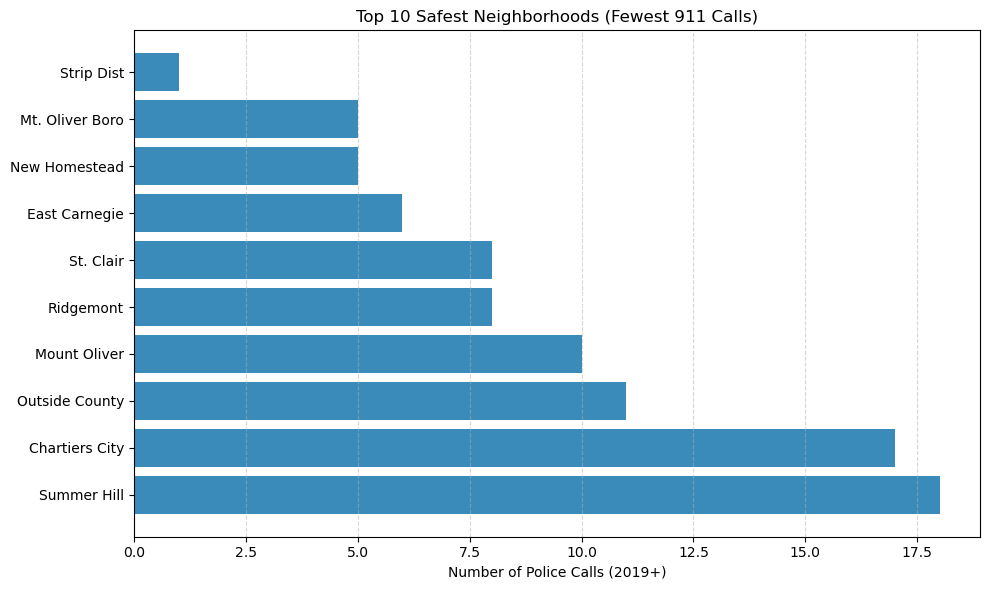

In [16]:
# Step 1: Make sure the date column is in datetime format
crime_df["INCIDENTTIME"] = pd.to_datetime(crime_df["INCIDENTTIME"], errors="coerce")

# Step 2: Only keep crimes from 2019 and later
crime_recent = crime_df[crime_df["INCIDENTTIME"].dt.year >= 2019]

# Step 3: Count how many times police showed up in each neighborhood
crime_counts = crime_recent["INCIDENTNEIGHBORHOOD"].value_counts().reset_index()
crime_counts.columns = ["neighborhood", "crime_calls"]

# Step 4: Find the neighborhood with the least number of calls (safest)
safest = crime_counts.sort_values("crime_calls").head(10)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.barh(safest["neighborhood"], safest["crime_calls"], color="#3b8bba")
plt.xlabel("Number of Police Calls (2019+)")
plt.title("Top 10 Safest Neighborhoods (Fewest 911 Calls)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Crime Data Analysis (2019–Present)

This chart shows the ten neighborhoods in Pittsburgh with the fewest police-reported incidents from 2021 onward. Fewer incidents suggest a lower crime rate and therefore a safer community.

Neighborhoods like **Strip District**, **Mt. Oliver Boro**, and **New Homestead** had the lowest number of calls, indicating a quieter and possibly safer environment. On the other hand, even though **Summer Hill** and **Chartiers City** are still in the top 10, they had noticeably more calls, showing a wider range even among the safest group.

We used the number of 911/police calls as a direct indicator of neighborhood safety. This raw count was later turned into a normalized "safety score" to fairly combine it with other metrics in our final ranking.


In [24]:
# Normalize the crime calls: lower calls = higher score (0 to 1)
# crime_score = 1 - (crime_calls - min) / (max - min)
crime_counts["crime_score"] = 1 - (
    (crime_counts["crime_calls"] - crime_counts["crime_calls"].min()) /
    (crime_counts["crime_calls"].max() - crime_counts["crime_calls"].min())
)

# Preview top neighborhoods with their crime scores
crime_counts.sort_values("crime_score", ascending=False).head(10)

,neighborhood,crime_calls,crime_score
94,Strip Dist,1,1.000000
93,Mt. Oliver Boro,5,0.996324
92,New Homestead,5,0.996324
91,East Carnegie,6,0.995404
89,St. Clair,8,0.993566
90,Ridgemont,8,0.993566
88,Mount Oliver,10,0.991728
87,Outside County,11,0.990809
86,Chartiers City,17,0.985294
84,Summer Hill,18,0.984375


## Dataset #2: School Enrollment

Here we calculate the total number of public school students enrolled in each neighborhood. Higher enrollment is used as a sign of strong school presence and family engagement in the community.

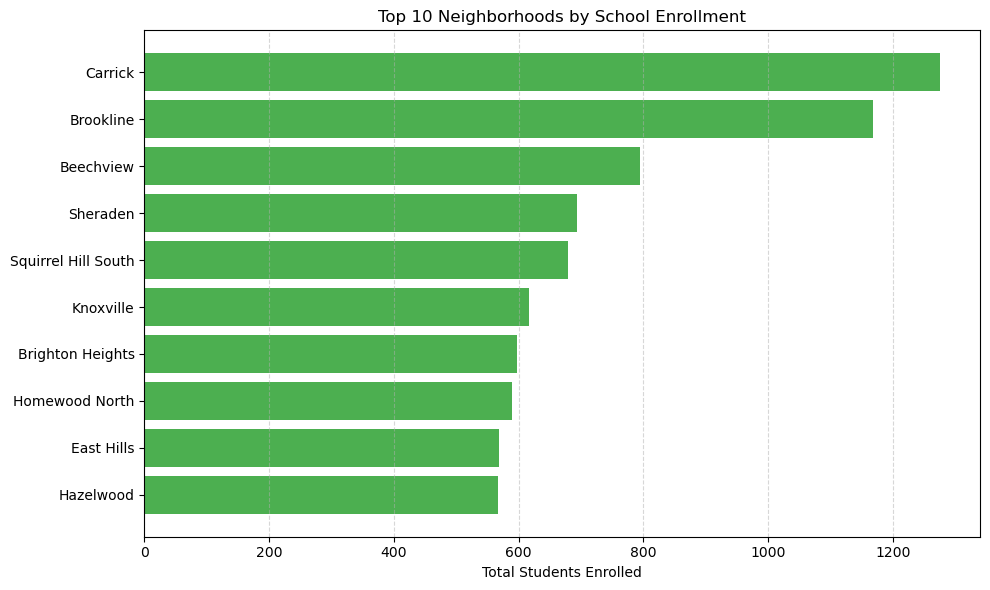

In [22]:
# Step 1: Drop any rows where enrollment is missing
school_df = school_df.dropna(subset=["total_students_enrolled"])

# Step 2: Group by neighborhood and sum total enrollment
school_totals = school_df.groupby("neighborhood")["total_students_enrolled"].sum().reset_index()

# Step 3: Normalize enrollment score (higher = better)
school_totals["school_score"] = (
    (school_totals["total_students_enrolled"] - school_totals["total_students_enrolled"].min()) /
    (school_totals["total_students_enrolled"].max() - school_totals["total_students_enrolled"].min())
)

# Step 4: Sort and take top 10 neighborhoods
top_school = school_totals.sort_values("school_score", ascending=False).head(10)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_school["neighborhood"], top_school["total_students_enrolled"], color="#4caf50")
plt.xlabel("Total Students Enrolled")
plt.title("Top 10 Neighborhoods by School Enrollment")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### School Enrollment Analysis

This chart shows the ten neighborhoods in Pittsburgh with the highest total public school enrollment. A higher number of enrolled students can be a strong indicator of a neighborhood with more families, stronger school presence, and better access to education.

Neighborhoods like **Carrick**, **Brookline**, and **Beechview** stood out with the most students enrolled, suggesting these areas are likely hubs for family life and school activity. Even neighborhoods like **Sheraden** and **Squirrel Hill South**, while lower on the list, still showed high engagement through school presence.

We used total student enrollment as a direct indicator of education access. This raw count was then normalized into a 0–1 **school score** to fairly combine it with other metrics in our final ranking.

In [26]:
# Normalize school enrollment: higher enrollment = higher score (0 to 1)
# school_score = (enrollment - min) / (max - min)
school_totals["school_score"] = (
    (school_totals["total_students_enrolled"] - school_totals["total_students_enrolled"].min()) /
    (school_totals["total_students_enrolled"].max() - school_totals["total_students_enrolled"].min())
)

# Preview top neighborhoods with their school scores
school_totals.sort_values("school_score", ascending=False).head(10)

,neighborhood,total_students_enrolled,school_score
14,Carrick,1276.0,1.000000
12,Brookline,1169.0,0.915348
6,Beechview,794.0,0.618671
62,Sheraden,694.0,0.539557
69,Squirrel Hill South,679.0,0.527690
38,Knoxville,616.0,0.477848
11,Brighton Heights,598.0,0.463608
35,Homewood North,589.0,0.456487
23,East Hills,569.0,0.440665
33,Hazelwood,567.0,0.439082


## Dataset #3: Vacancy Rate (Neighborhood Stability)

Here we calculate the percentage of vacant homes in each neighborhood using data from the Pittsburgh Neighborhood Profiles. A lower vacancy rate is used as a sign of greater housing stability and long-term residency, both of which are often important for family-friendly communities.

Neighborhoods with fewer vacant homes are typically more desirable and indicate stronger neighborhood investment and consistency over time. High vacancy, on the other hand, can suggest instability or limited housing demand.

We used the vacancy percentage as a direct measure of neighborhood stability, and normalized it into a 0–1 **vacancy score**, where lower vacancy leads to a higher score.


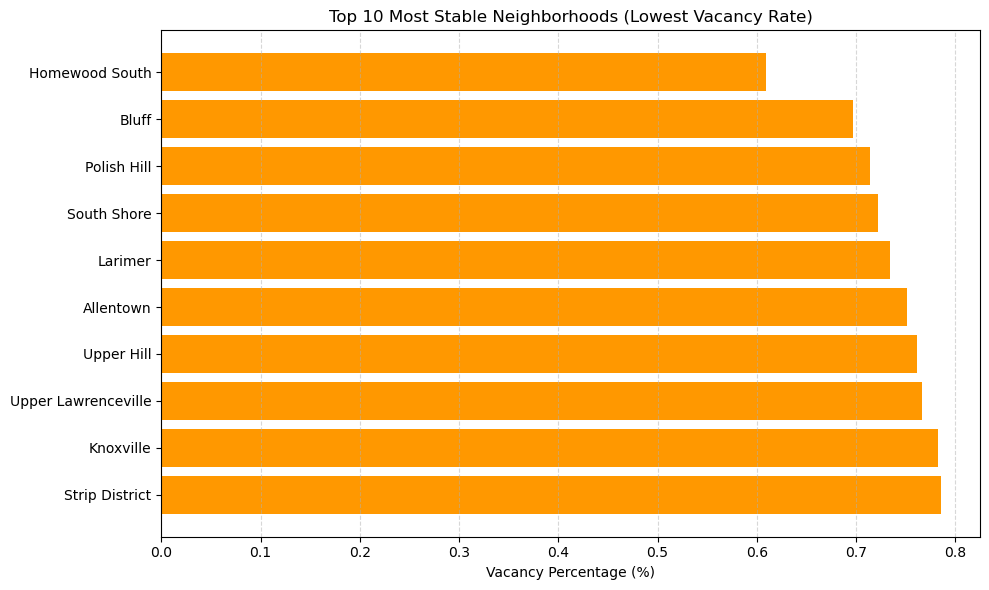

In [32]:
# Step 1: Filter for only neighborhoods (exclude non-neighborhood entries)
vacancy_neigh = vacancy_df[vacancy_df["GeographyType"] == "neighborhood"]

# Step 2: Select neighborhood name and 2022 vacancy percentage
vacancy_data = vacancy_neigh[["NeighborhoodGroup", "Var_2022_vacancy_Per_2"]].copy()
vacancy_data.columns = ["neighborhood", "vacancy_percent"]

# Step 3: Drop missing values
vacancy_data = vacancy_data.dropna()

# Step 4: Sort to find neighborhoods with the lowest vacancy rates
lowest_vacancy = vacancy_data.sort_values("vacancy_percent").head(10)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.barh(lowest_vacancy["neighborhood"], lowest_vacancy["vacancy_percent"], color="#ff9800")
plt.xlabel("Vacancy Percentage (%)")
plt.title("Top 10 Most Stable Neighborhoods (Lowest Vacancy Rate)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Vacancy Rate Analysis

This chart shows the ten neighborhoods in Pittsburgh with the lowest housing vacancy percentages, which we used as a sign of neighborhood stability. A lower vacancy rate suggests that more homes are occupied and the area has a stronger sense of community, which can be appealing for families.

Neighborhoods like **Homewood South**, **Bluff**, and **Polish Hill** had the fewest vacant homes, indicating they are more stable and possibly more desirable for long-term residency. These areas may reflect stronger community investment and higher demand for housing.

We used the vacancy percentage as a direct indicator of housing stability. This raw value was then normalized into a 0–1 **vacancy score**, where lower vacancy resulted in a higher score. This allowed us to fairly combine it with other metrics in our final ranking.

In [34]:
# Normalize vacancy rate: lower vacancy = higher score (0 to 1)
# vacancy_score = 1 - (vacancy_percent - min) / (max - min)
vacancy_data["vacancy_score"] = 1 - (
    (vacancy_data["vacancy_percent"] - vacancy_data["vacancy_percent"].min()) /
    (vacancy_data["vacancy_percent"].max() - vacancy_data["vacancy_percent"].min())
)

# Preview top neighborhoods with their vacancy scores
vacancy_data.sort_values("vacancy_score", ascending=False).head(10)

,neighborhood,vacancy_percent,vacancy_score
36,Homewood South,0.609091,1.000000
14,Bluff,0.696970,0.757686
54,Polish Hill,0.714120,0.710396
57,South Shore,0.722222,0.688056
38,Larimer,0.733990,0.655608
7,Allentown,0.751356,0.607725
68,Upper Hill,0.761208,0.580559
69,Upper Lawrenceville,0.766846,0.565011
37,Knoxville,0.782535,0.521751
64,Strip District,0.785714,0.512985


## Best Neighborhood Final Score: Combining All Metrics

Now that we’ve calculated individual scores for each neighborhood based on crime, school enrollment, and vacancy rate, we combine them to create a single, overall score.

Each score was normalized between 0 and 1 to ensure fairness, where **higher values always indicate better performance** (i.e., safer, more stable, or more family-friendly). The final score is calculated as the average of the three individual scores:

final_score = (crime_score + school_score + vacancy_score) / 3


This final score allows us to rank all Pittsburgh neighborhoods and determine which one offers the most balanced combination of safety, education access, and housing stability, helping us identify the overall **best neighborhood for families**.

In [36]:
# Step 1: Merge all three score tables on "neighborhood"
final_df = crime_counts[["neighborhood", "crime_score"]].merge(
    school_totals[["neighborhood", "school_score"]],
    on="neighborhood", how="inner"
).merge(
    vacancy_data[["neighborhood", "vacancy_score"]],
    on="neighborhood", how="inner"
)

# Step 2: Calculate the average of the three scores
final_df["final_score"] = final_df[["crime_score", "school_score", "vacancy_score"]].mean(axis=1)

# Step 3: Sort and display top 10 neighborhoods
top_final = final_df.sort_values("final_score", ascending=False).head(10)
top_final

,neighborhood,crime_score,school_score,vacancy_score,final_score
10,Homewood South,0.723346,0.367880,1.000000,0.697075
1,Carrick,0.470588,1.000000,0.306895,0.592494
12,Knoxville,0.744485,0.477848,0.521751,0.581362
15,East Hills,0.770221,0.440665,0.476582,0.562489
3,Brookline,0.627757,0.915348,0.128677,0.557261
42,Polish Hill,0.943015,0.017405,0.710396,0.556939
17,Larimer,0.818015,0.193038,0.655608,0.555553
18,Allentown,0.825368,0.215190,0.607725,0.549427
34,Upper Hill,0.920037,0.104430,0.580559,0.535009
37,Upper Lawrenceville,0.929228,0.079114,0.565011,0.524451


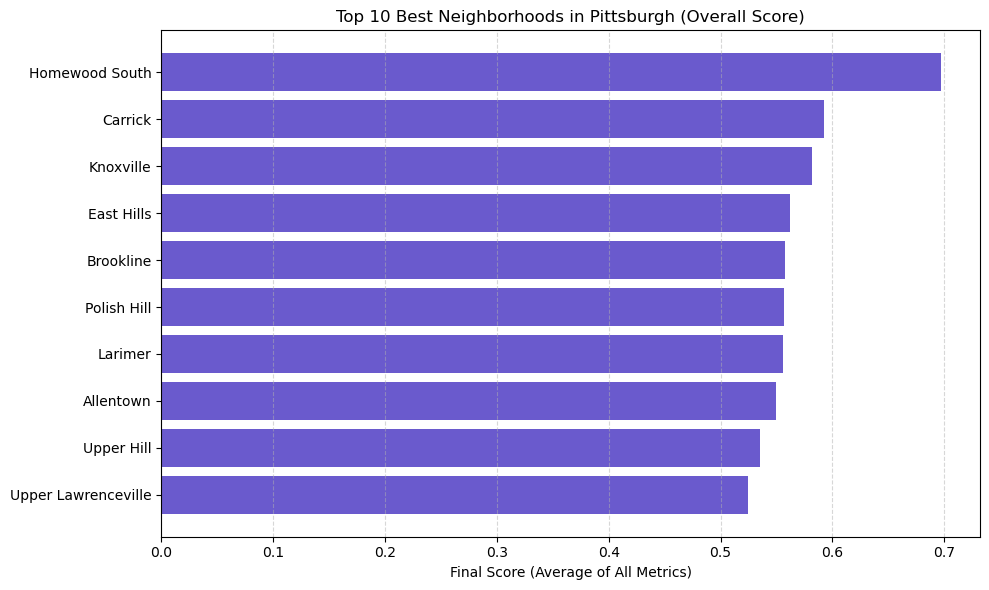

In [31]:
# Plot top 10 neighborhoods by final score
plt.figure(figsize=(10, 6))
plt.barh(top_final["neighborhood"], top_final["final_score"], color="#6a5acd")
plt.xlabel("Final Score (Average of All Metrics)")
plt.title("Top 10 Best Neighborhoods in Pittsburgh (Overall Score)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

After calculating scores for each Pittsburgh neighborhood based on crime rate, school enrollment, and housing vacancy, we combined them into a final average score. Each of the three metrics was normalized on a 0 to 1 scale so that all categories were weighted equally. This gave us a fair way to rank neighborhoods using real, measurable data.

Based on our final combined score, **Homewood South** came out as the best overall neighborhood for families. It had a strong balance across all three categories, especially excelling in housing stability with the **lowest vacancy rate** in the city. While it did not rank first in school enrollment or crime score, its consistent performance across all areas led to the highest average.

This shows that a neighborhood doesn’t have to be number one in everything to be the best overall, consistency across important categories can make a big difference. Other neighborhoods like **Carrick** and **Knoxville** also scored well in some areas but were slightly less balanced in others.

## Conclusion

After analyzing data from three key areas, crime, school enrollment, and vacancy rates — we found that Homewood South ranked as the best neighborhood in Pittsburgh for families. It performed especially well in housing stability, with the lowest vacancy rate overall, and also did well in safety. While it wasn’t the top in school enrollment, it had a solid score across all categories.

This project showed us that the best neighborhood isn’t always the one with the highest score in one area, but the one that’s most balanced across important factors. It also helped us understand how data can reveal patterns and qualities about neighborhoods we might not have noticed before.

### Individual Reflections

**Josh:**  
My favorite neighborhood is South Oakland because it’s busy and walkable. Even though it didn’t score highest in our rankings, I still like it for personal reasons. This project showed me how personal experience and data can tell different stories.

**Nabeel:**  
My favorite neighborhood is the Strip District. It’s one of the most unique areas in the city. It didn’t rank number one in our project, but it still performed well in some categories. I learned that data helps you think about neighborhoods in a more objective way.